In [1]:
from core.datasets import LPDataset
from core.coders import Encoder, Decoder, Reducer
from core.networks import CRNN

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

In [2]:
CHARACTERS = [
    '_', 'A', 'B', 'C', 'D', 'E',
    'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'Q',
    'R', 'S', 'T', 'U', 'V', 'W',
    'X', 'Y', 'Z', '0', '1', '2',
    '3', '4', '5', '6', '7', '8',
    '9'
]

In [3]:
preprocess = {
    "train": transforms.Compose([
        transforms.Resize((32, 128)),
        transforms.ToTensor()
    ]),
    "val": transforms.Compose([
        transforms.Resize((32, 128)),
        transforms.ToTensor()
    ])
}

In [4]:
datasets = {
    x: LPDataset(
        root= "./data",
        train = True if x == "train" else False,
        transform = preprocess[x],
        target_transform = Encoder(CHARACTERS),
    )
    for x in ["train", "val"]
}

In [5]:
datasets["train"]

Dataset LPDataset
    Number of datapoints: 10821
    Root location: data
    Split: Train
    Compose(
    Resize(size=(32, 128), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)

In [6]:
datasets["val"]

Dataset LPDataset
    Number of datapoints: 561
    Root location: data
    Split: Test
    Compose(
    Resize(size=(32, 128), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)

In [7]:
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=32,
        shuffle=False,
        num_workers=4
    )
    for x in ["train", "val"]
}

dataset_sizes = {
    x: len(datasets[x])
    for x in ["train", "val"]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def imshow(inp, title=None):
    """ Imshow for Tensor """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap=plt.cm.gray)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

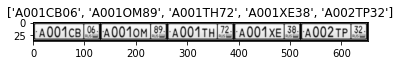

In [9]:
decoder = Decoder(CHARACTERS)
inputs, targets = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[decoder(target) for target in targets[:5]])

In [10]:
def visualize_model(model, reducer, decoder, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 2)
            preds = preds.transpose(1, 0).contiguous()
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(decoder(reducer(preds[j].cpu()))))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

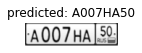

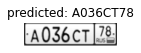

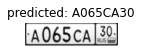

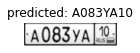

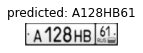

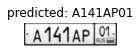

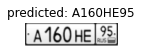

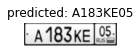

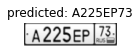

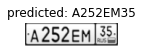

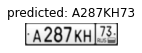

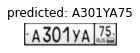

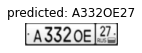

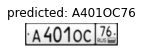

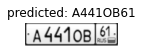

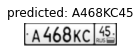

In [11]:
model = CRNN(32, 1, len(CHARACTERS), 256).to(device)
model.load_state_dict(torch.load("./save/crnn.pth"))
reducer = Reducer(8)
decoder = Decoder(CHARACTERS)
visualize_model(model, reducer, decoder, num_images=16)